In [1]:
import numpy as np 
from datasets import load_dataset
import pandas as pd 
import torch as t 
import torch.nn as nn

import tqdm.notebook as tqdm

%matplotlib inline
import matplotlib.pyplot as plt

# Problem 1
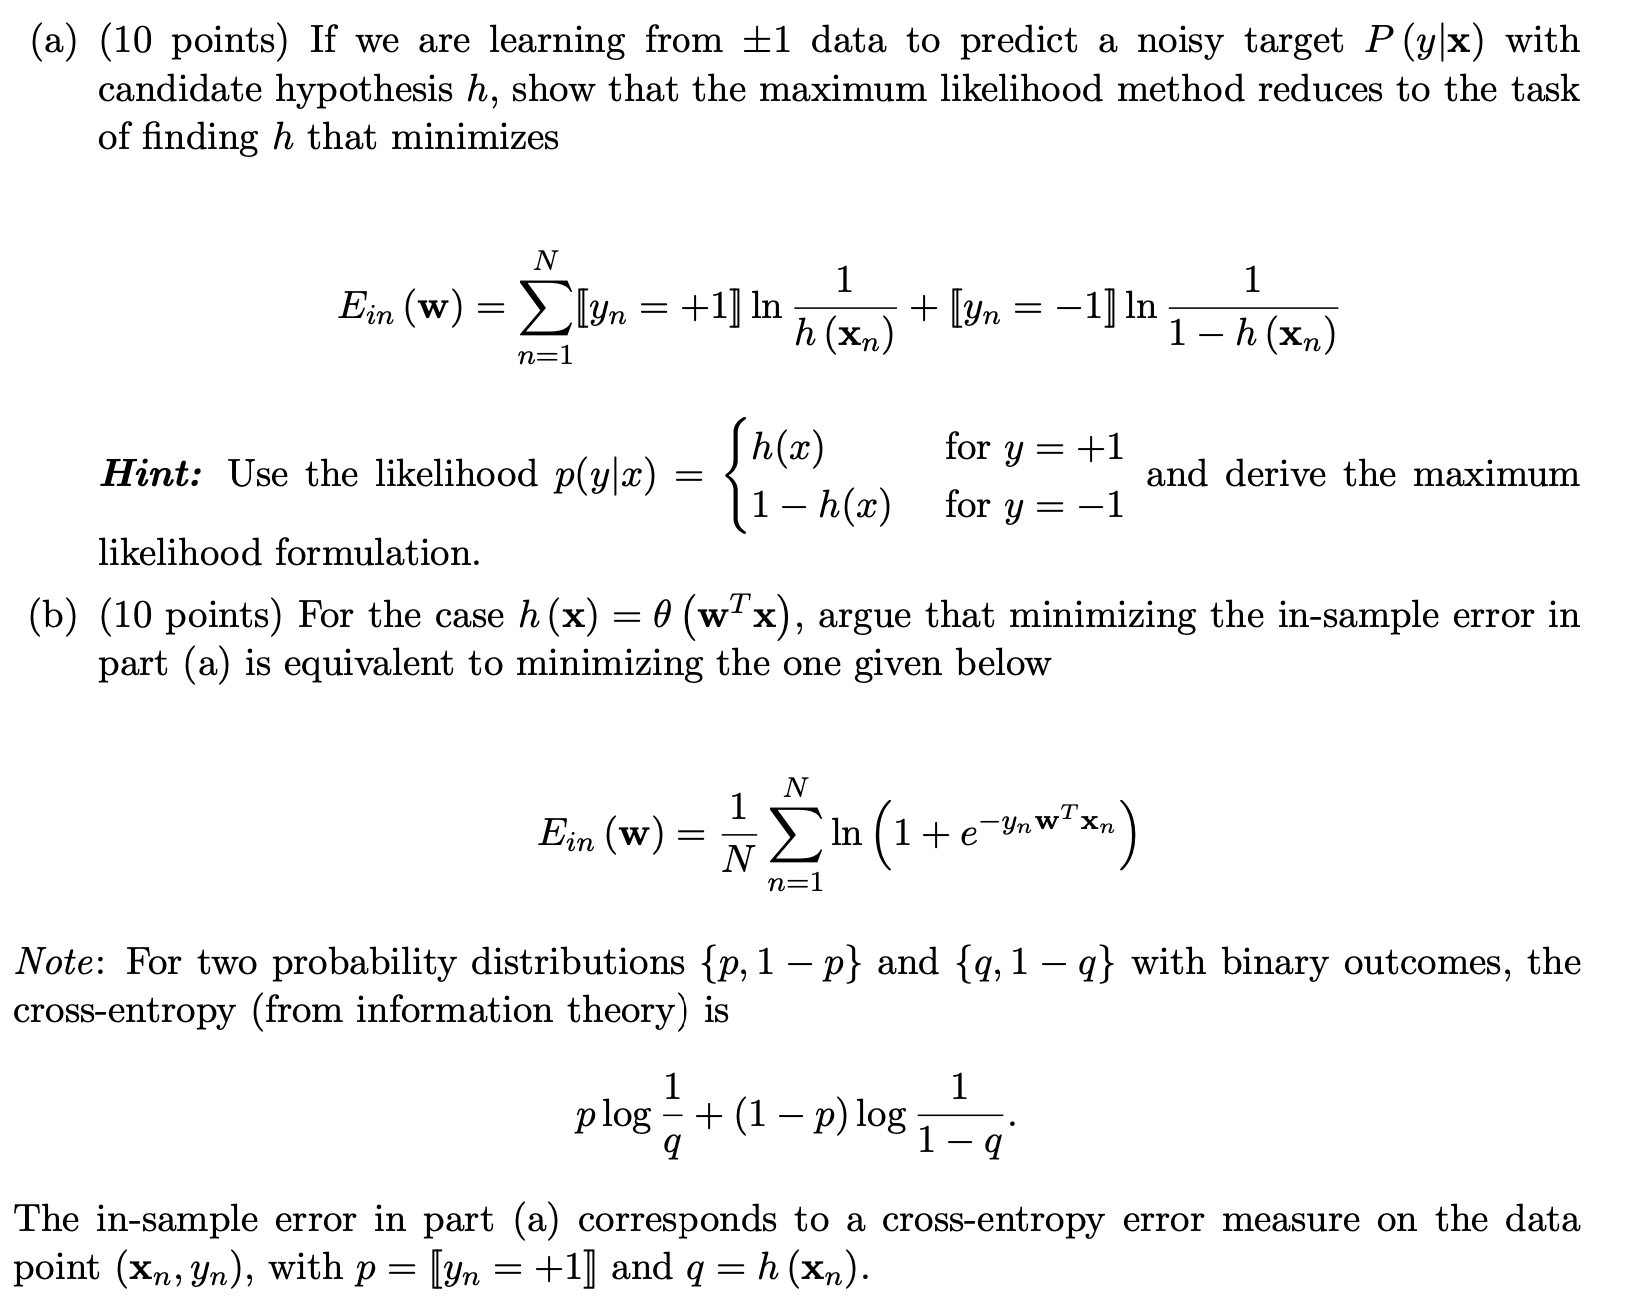

(a) likelihood is $\mathcal{L} = \prod_i p(y_i | \mathbf{x}_i)$

log-likelihood is $\log \mathcal{L} = \sum_i \log p(y_i | \mathbf{x}_i)$

We have $p(y | \mathbf{x}) = h(\mathbf{x})$ if $y = +1$ and $p(y | \mathbf{x}) = 1- h(\mathbf{x})$ if $y = -1$

So if we sum over all $i$, we get a $\log h$ term for positive labels and a $\log (1 - h)$ term for negative labels.

Maximizing the log-likelihood is the same as minimizing the negative log-likelihood. So we put a minus sign in front of sum to get the negative log likelihood, and we use $-\log(A) = \log(1/A)$. From there, we get the $E$ expression listed!

(b) for $h(\mathbf{x}) = \theta(\mathbf{w}^T\mathbf{x})$, with $\theta(a) = \frac{1}{1 + e^{-a}}$, note that

if $y = +1$, $h(\mathbf{x}) = \theta(\mathbf{w}^T\mathbf{x})$. If $y = -1$, $h(\mathbf{x}) = 1-\theta(\mathbf{w}^T\mathbf{x}) = \frac{e^{-\mathbf{w}^T\mathbf{x}}}{1 + e^{-\mathbf{w}^T\mathbf{x}}} = \frac{1}{1 + e^{\mathbf{w}^T\mathbf{x}}}$

Or, more succinctly, $h(\mathbf{x}) = \frac{1}{1 + e^{-y \mathbf{w}^T\mathbf{x}}}$, which is general for any sign of y.

From this expression, we can just take the log-likelihood which is $-\ln(h) = \ln\left(1 + e^{-y\mathbf{w}^T\mathbf{x}}\right)$, which is what we were seeking.

# Problem 2
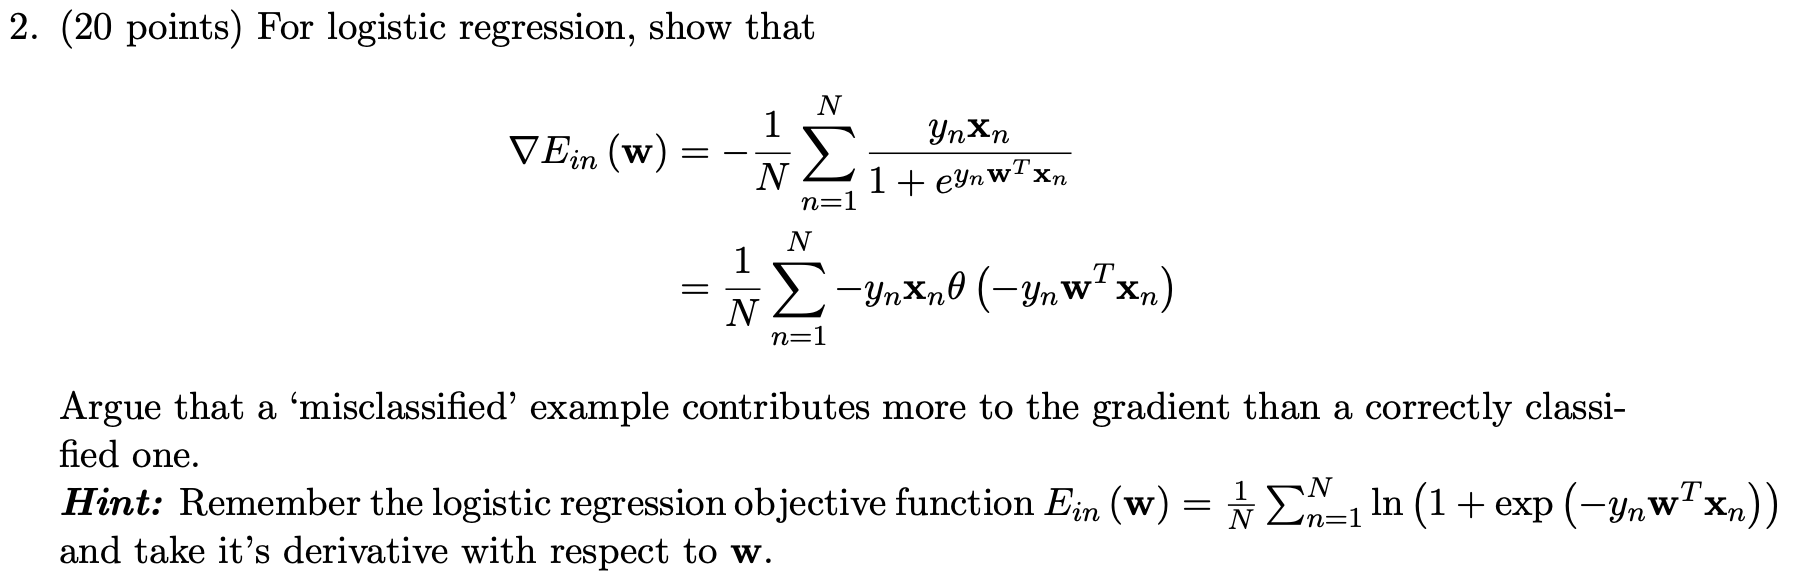

(a) Starting from $E_{in} = \frac{1}{N}\sum_{i=1}^N \ln \left(1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}\right)$, we take a derivative w.r.t. $\mathbf{x}$.

Derivative of a natural log is 1/(arguments) times derivative (arguments) so $\nabla \ln \left(1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}\right) = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}\nabla e^{-y_n \mathbf{w}^T \mathbf{x}_n} = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}e^{-y_n \mathbf{w}^T \mathbf{x}_n} \nabla(-y_n \mathbf{w}^T \mathbf{x}_n) = \frac{1}{1 + e^{-y_n \mathbf{w}^T \mathbf{x}_n}}e^{-y_n \mathbf{w}^T \mathbf{x}_n} (-y_n \mathbf{x}_n)$.

Multiplying the top and bottom by $e^{y_n \mathbf{w}^T \mathbf{x}_n}$, we arrive at the desired answer:
$\nabla E_{in} = -\frac{1}{N}\sum_{i=1}^N \frac{y_n \mathbf{x}_n}{1 + e^{y_n \mathbf{w}^T \mathbf{x}_n}} = 
-\frac{1}{N}\sum_{i=1}^N y_n \mathbf{x}_n \theta(y_n \mathbf{w}^T \mathbf{x}_n)$, where the last part comes from the definition of the sigmoid function $\theta$.

(b) In a correctly classified example, $y_n \mathbf{w}^T \mathbf{x}_n > 0$, whereas in an incorrectly classified example, $y_n \mathbf{w}^T \mathbf{x}_n < 0$. The sigmoid function $\theta$ goes from 0 (at $-\infty$) to 1 (at $+\infty$), so the sigmoid function amplifies misclassified examples since its argument is $-y_n \mathbf{w}^T \mathbf{x}_n$.

# Problem 3
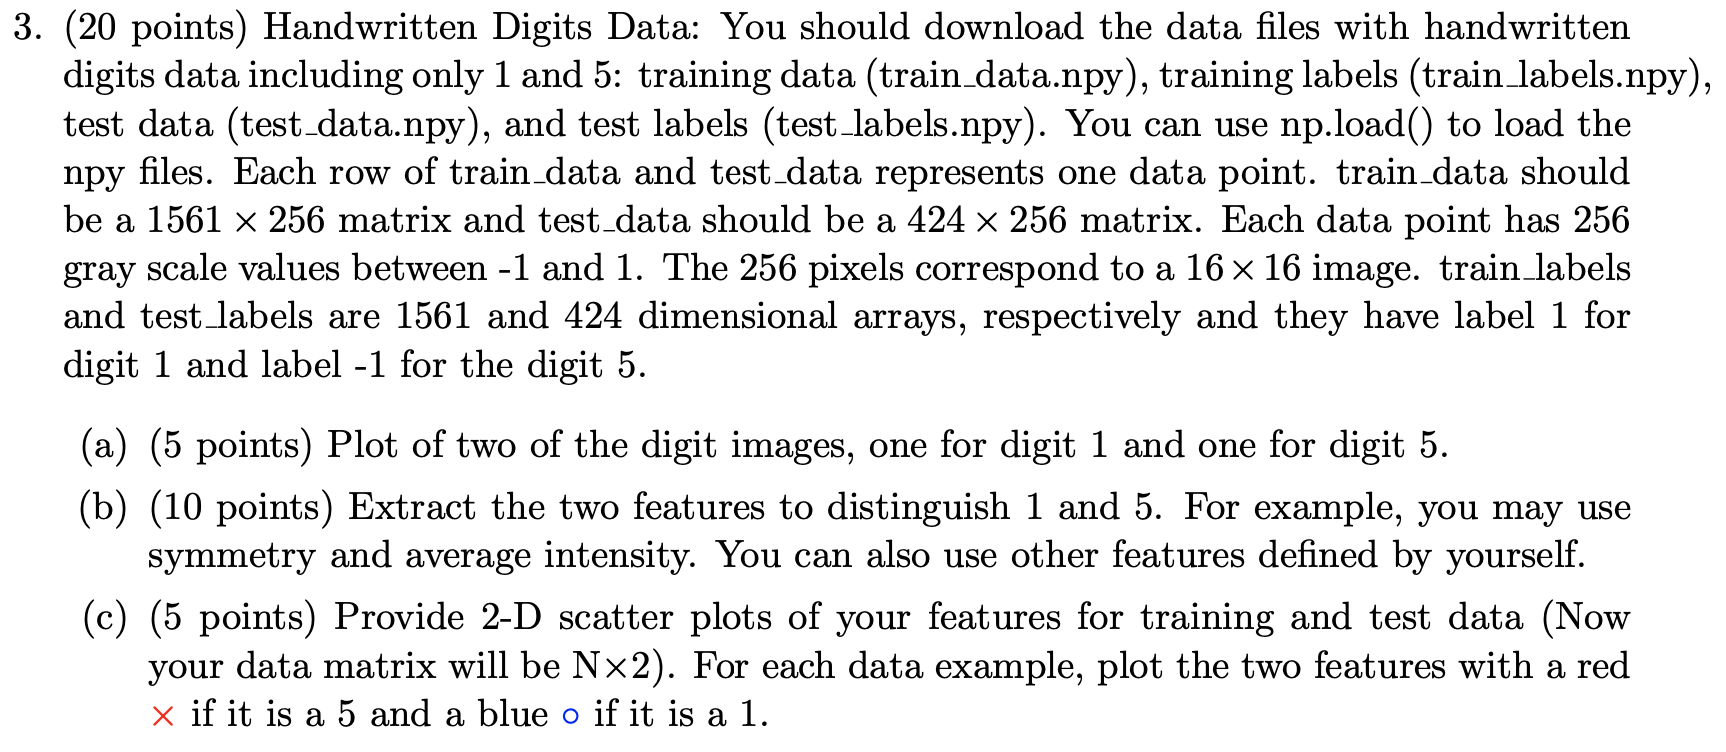

In [2]:
# Load MNIST and split into train and test
mnist = load_dataset('mnist')

train = mnist['train']
labels = np.array(train['label'])
good = np.logical_or(labels == 1, labels == 5)
train = train.select(np.arange(labels.size)[good])

test = mnist['test']
labels = np.array(test['label'])
good = np.logical_or(labels == 1, labels == 5)
test = test.select(np.arange(labels.size)[good])

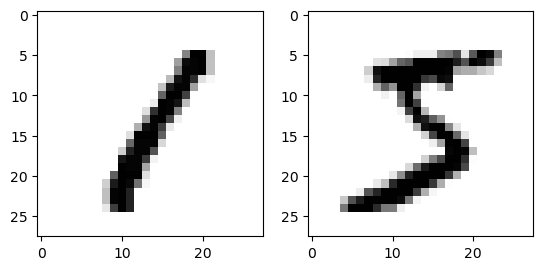

In [3]:
#(a) plot a 1 and a 5
fig, axs = plt.subplots(1, 2)

one_indices = np.where(np.array(train['label']) == 1)[0]
five_indices = np.where(np.array(train['label']) == 5)[0]

one_img = train['image'][one_indices[0]]
axs[0].imshow(one_img, cmap='gray_r')

five_img = train['image'][five_indices[0]]
axs[1].imshow(five_img, cmap='gray_r')


In [4]:
#extract features: symmetry, intensity


def extract_features(dataset):
    images = np.array(dataset['image'])
    labels = np.array(dataset['label'])
    n_pix = images.shape[1]
    flat_images = images.reshape(images.shape[0], -1)

    img_avg = np.mean(flat_images, axis=1)

    #symmetry (top-down, left-right)
    left = images[:, :n_pix//2]
    right = images[:, n_pix//2:]
    top = images[:, :, :n_pix//2]
    bottom = images[:, :, n_pix//2:]

    lr_sym = np.mean(np.abs(left - right[:,::-1]), axis=(1, 2))
    tb_sym = np.mean(np.abs(top - bottom[:,:,::-1]), axis=(1, 2))

    img_avg /= img_avg.max()
    lr_sym /= lr_sym.max()
    tb_sym /= tb_sym.max()

    return labels, np.stack([img_avg, lr_sym, tb_sym], axis=1)

test_labels, test_features = extract_features(test)
train_labels, train_features = extract_features(train)
print(train_features.shape)

(12163, 3)


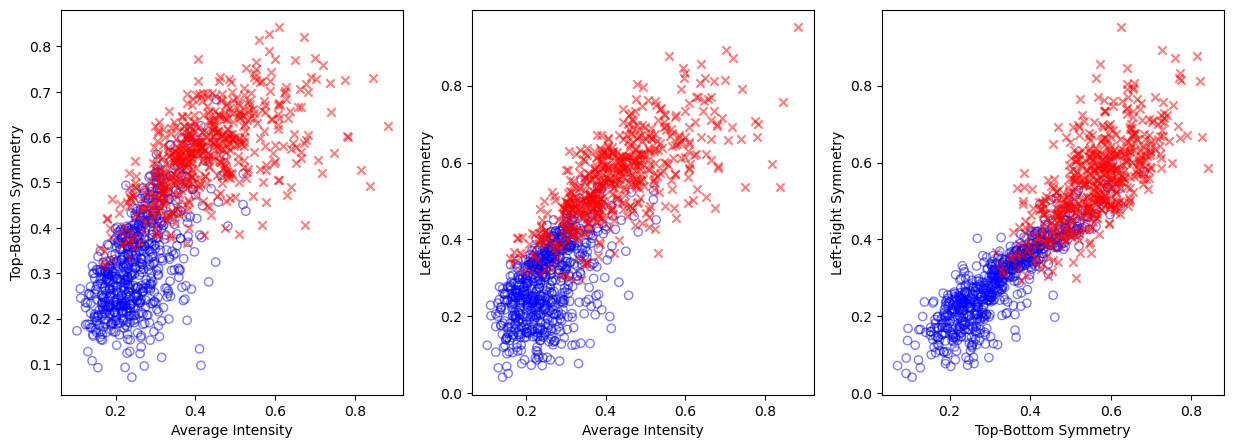

In [5]:
# 3 scatterplots: intensity vs tb symmetry, intensity vs lr symmetry, tb symmetry vs lr symmetry
@t.inference_mode()
def plot_scatters(data=train_features, one_indices=one_indices, five_indices=five_indices, regresser = None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    img_avg = data[:, 0]
    lr_sym = data[:, 1]
    tb_sym = data[:, 2]
    axs[0].scatter(img_avg[one_indices][::10], tb_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
    axs[0].scatter(img_avg[five_indices][::10], tb_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
    axs[0].set_xlabel('Average Intensity')
    axs[0].set_ylabel('Top-Bottom Symmetry')

    axs[1].scatter(img_avg[one_indices][::10], lr_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
    axs[1].scatter(img_avg[five_indices][::10], lr_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
    axs[1].set_xlabel('Average Intensity')
    axs[1].set_ylabel('Left-Right Symmetry')

    axs[2].scatter(tb_sym[one_indices][::10], lr_sym[one_indices][::10], edgecolor='b', marker='o', facecolors='none', alpha=0.5)
    axs[2].scatter(tb_sym[five_indices][::10], lr_sym[five_indices][::10], c='r', marker='x', alpha=0.5)
    axs[2].set_xlabel('Top-Bottom Symmetry')
    axs[2].set_ylabel('Left-Right Symmetry')

    if regresser is not None:
        # plot decision boundary
        x1 = np.linspace(img_avg.min(), img_avg.max(), 100)
        x2 = np.linspace(tb_sym.min(), tb_sym.max(), 100)
        line1 = (regresser.weights[0] + regresser.weights[1]*x1 + regresser.weights[2]*lr_sym.mean())/-regresser.weights[3]
        line2 = (regresser.weights[0] + regresser.weights[1]*x1 + regresser.weights[3]*tb_sym.mean())/-regresser.weights[2]
        line3 = (regresser.weights[0] + regresser.weights[3]*x2 + regresser.weights[1]*img_avg.mean())/-regresser.weights[2]

        axs[0].plot(x1, line1, 'k-')
        axs[1].plot(x1, line2, 'k-')
        axs[2].plot(x2, line3, 'k-')
plot_scatters()

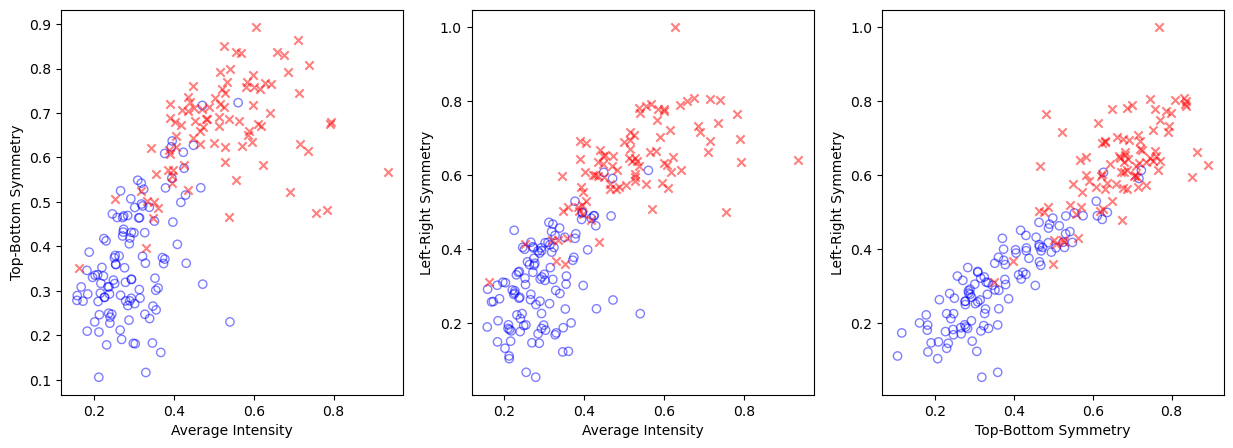

In [6]:
test_one_indices = np.where(np.array(test['label']) == 1)[0]
test_five_indices = np.where(np.array(test['label']) == 5)[0]
plot_scatters(data=test_features, one_indices=test_one_indices, five_indices=test_five_indices)

# Problem 4
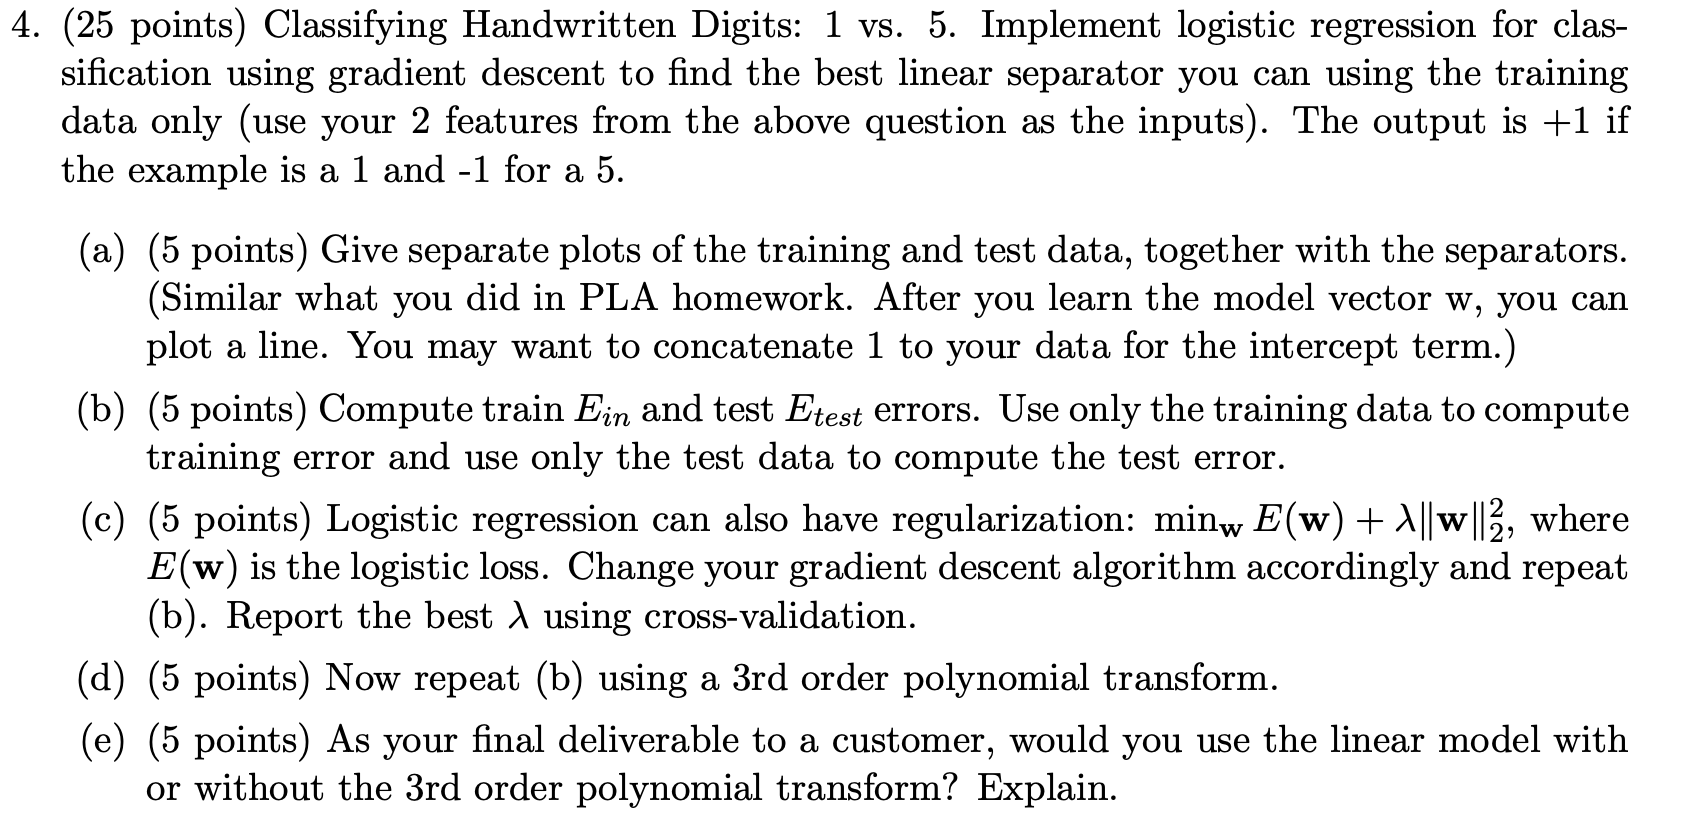

In [7]:
class LogisticRegresser(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegresser, self).__init__()
        self.weights = nn.Parameter(t.rand(input_dim+1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = t.cat([t.ones(x.shape[0], 1), x], dim=1)
        return t.einsum('ij,jk->ik', x, self.weights)

    def prob(self, x):
        return self.sigmoid(self.forward(x))

    def loss(self, x, y):
        return t.mean(t.log(1 + t.exp(-y * self.forward(x))))

losses = []

train_features_fixed = t.tensor(train_features, dtype=t.float32)
test_features_fixed = t.tensor(test_features, dtype=t.float32)
train_labels_fixed = t.Tensor(np.where(train_labels == 1, 1, -1))
test_labels_fixed = t.Tensor(np.where(test_labels == 1, 1, -1))

regresser = LogisticRegresser(train_features.shape[1])
optimizer = t.optim.SGD(regresser.parameters(), lr=1e-2)
batch_size = 10000
iterations = 10000
for iter in tqdm.tqdm(range(iterations)):
    optimizer.zero_grad()

    # randomly pick a batch from the whole train dataset
    indices = np.random.choice(train_features.shape[0], batch_size)
    batch_features = t.tensor(train_features[indices], dtype=t.float32)
    batch_labels = t.tensor(train_labels_fixed[indices], dtype=t.float32).view(-1, 1)

    # Get predictions
    loss = regresser.loss(batch_features, batch_labels)
    loss.backward()
    optimizer.step()

    with t.inference_mode():
        train_loss = regresser.loss(train_features_fixed, train_labels_fixed.view(-1, 1))
        test_loss = regresser.loss(test_features_fixed, test_labels_fixed.view(-1, 1))
        losses.append((train_loss.item(), test_loss.item()))

train_loss, test_loss = [np.array(l) for l in zip(*losses)]
print(train_loss[-1], test_loss[-1])

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_17318/1778471516.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = t.tensor(train_labels_fixed[indices], dtype=t.float32).view(-1, 1)


0.40279775857925415 0.39621928334236145


(a)

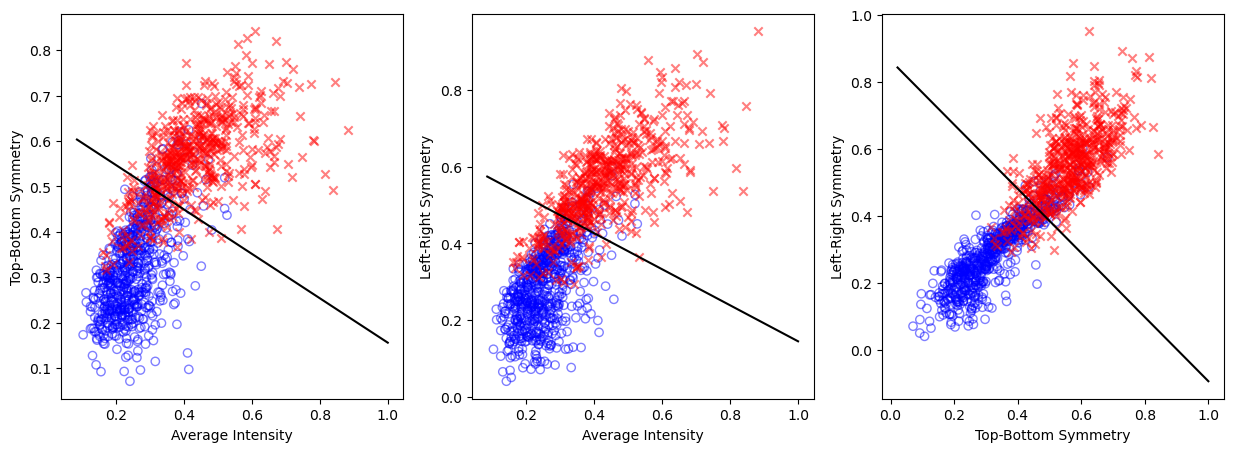

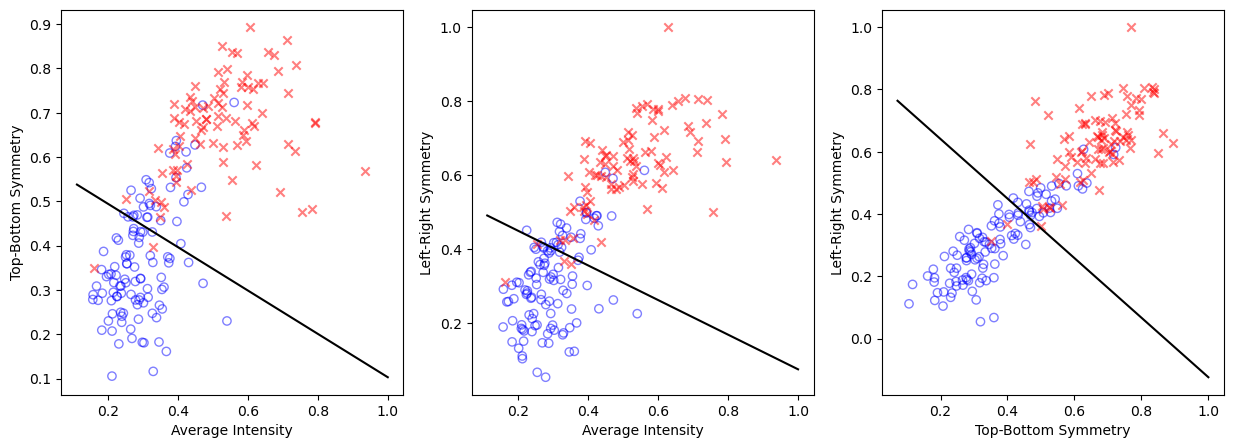

In [8]:
plot_scatters(regresser=regresser)
plot_scatters(data=test_features, one_indices=test_one_indices, five_indices=test_five_indices, regresser=regresser)

(b)


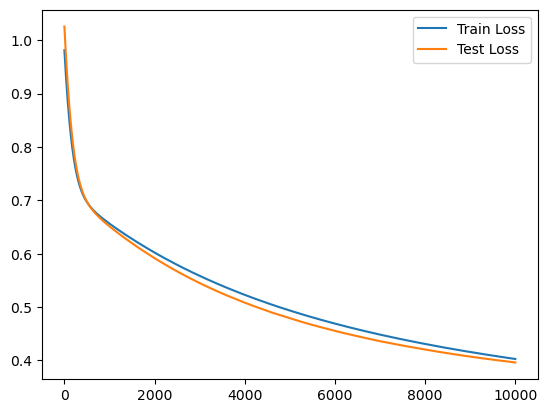

In [9]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()

(c) Best lambda is in the vicinity of 1e-2ish.

In [10]:
from IPython.display import clear_output
class RidgeLogisticRegresser(LogisticRegresser):

    def __init__(self, input_dim, lam):
        super().__init__(input_dim)
        self.lam = lam

    def loss(self, x, y):
        loss = super().loss(x, y)
        return loss + self.lam * self.weights[1:].norm()**2

#I'm not doing cross-validation in its truest since, but since I'm doing mini-batch SGD with a larger dataset than homework originally called for, this is similar.


lams = np.logspace(-3, 3, 7)
all_losses = []
batch_size = 10000
iterations = 10000
for lam in lams:
    retry = True

    while retry:

        losses = []
        regresser = RidgeLogisticRegresser(train_features.shape[1], lam=lam)
        optimizer = t.optim.SGD(regresser.parameters(), lr=1e-3)
        for iter in tqdm.tqdm(range(iterations)):
            optimizer.zero_grad()

            # randomly pick a batch from the whole train dataset
            indices = np.random.choice(train_features.shape[0], batch_size)
            batch_features = t.tensor(train_features[indices], dtype=t.float32)
            batch_labels = t.tensor(train_labels_fixed[indices], dtype=t.float32).view(-1, 1)

            # Get predictions
            loss = regresser.loss(batch_features, batch_labels)
            loss.backward()
            optimizer.step()

            with t.inference_mode():
                train_loss = regresser.loss(train_features_fixed, train_labels_fixed.view(-1, 1))
                test_loss = regresser.loss(test_features_fixed, test_labels_fixed.view(-1, 1))
                losses.append((train_loss.item(), test_loss.item()))
            if not np.isfinite(losses[-1][0]):
                break
        if np.isfinite(losses[-1][0]):
            retry = False
    clear_output()
    all_losses.append(losses)



[0.6852033138275146, 0.6441512107849121, 0.6737592816352844, 0.6849198937416077, 0.6872992515563965, 0.6872389912605286, 4606.54443359375]


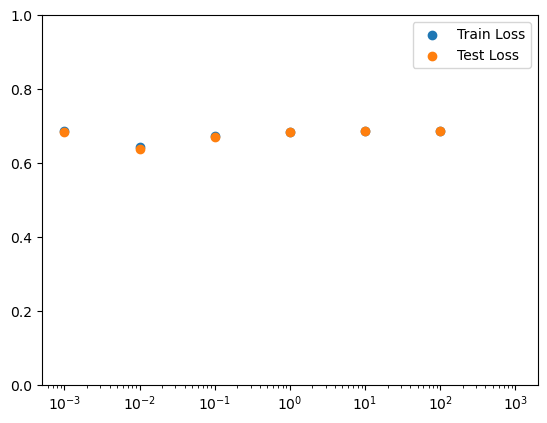

In [13]:

plt.scatter(lams, [loss[-1][0] for loss in all_losses], label='Train Loss')
plt.scatter(lams, [loss[-1][1] for loss in all_losses], label='Test Loss')
plt.xscale('log')
plt.yscale('linear')
plt.ylim(0, 1)
plt.legend()

print([loss[-1][0] for loss in all_losses])

(d) Now we do a 3rd order polynomial expansion, so our features columns are $[1, x_1, x_2, x_3, x_1^2, x_2^2, x_3^2, x_1x_2, x_1x_3, x_2x_3, x_1^3, x_2^3, x_3^3, x_1x_2x_3, x_1^2x_2, x_1^2x_3, x_2^2x_1, x_2^2x_3, x_3^2x_1, x_3^2x_2]$

In [16]:

def extract_cubic_features(dataset):
    images = np.array(dataset['image'])
    labels = np.array(dataset['label'])
    n_pix = images.shape[1]
    flat_images = images.reshape(images.shape[0], -1)

    x1 = np.mean(flat_images, axis=1)

    #symmetry (top-down, left-right)
    left = images[:, :n_pix//2]
    right = images[:, n_pix//2:]
    top = images[:, :, :n_pix//2]
    bottom = images[:, :, n_pix//2:]

    x2 = np.mean(np.abs(left - right[:,::-1]), axis=(1, 2))
    x3 = np.mean(np.abs(top - bottom[:,:,::-1]), axis=(1, 2))

    #Normalization is important here!
    x1 /= x1.max()
    x2 /= x2.max()
    x3 /= x3.max()

    return labels, np.stack([x1, x2, x3, 
                             x1**2, x2**2, x3**2, x1*x2, x1*x3, x2*x3, 
                             x1**3, x2**3, x3**3, x1*x2*x3, x1**2*x2, x1**2*x3, x2**2*x1, x2**2*x3, x3**2*x1, x3**2*x2], axis=1)

cubic_test_labels, cubic_test_features = extract_cubic_features(test)
cubic_train_labels, cubic_train_features = extract_cubic_features(train)

cubic_train_features_fixed = t.tensor(cubic_train_features, dtype=t.float32)
cubic_test_features_fixed = t.tensor(cubic_test_features, dtype=t.float32)
cubic_train_labels_fixed = t.Tensor(np.where(cubic_train_labels == 1, 1, -1))
cubic_test_labels_fixed = t.Tensor(np.where(cubic_test_labels == 1, 1, -1))

regresser = LogisticRegresser(cubic_train_features.shape[1])
optimizer = t.optim.SGD(regresser.parameters(), lr=1e-2)
batch_size = 10000
iterations = 10000
losses = []
for iter in tqdm.tqdm(range(iterations)):
    optimizer.zero_grad()

    # randomly pick a batch from the whole train dataset
    indices = np.random.choice(cubic_train_features.shape[0], batch_size)
    batch_features = t.tensor(cubic_train_features[indices], dtype=t.float32)
    batch_labels = t.tensor(cubic_train_labels_fixed[indices], dtype=t.float32).view(-1, 1)

    # Get predictions
    loss = regresser.loss(batch_features, batch_labels)
    loss.backward()
    optimizer.step()

    with t.inference_mode():
        train_loss = regresser.loss(cubic_train_features_fixed, cubic_train_labels_fixed.view(-1, 1))
        test_loss = regresser.loss(cubic_test_features_fixed, cubic_test_labels_fixed.view(-1, 1))
        losses.append((train_loss.item(), test_loss.item()))

train_loss, test_loss = [np.array(l) for l in zip(*losses)]
print(train_loss[-1], test_loss[-1])

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_17318/3821983169.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_labels = t.tensor(cubic_train_labels_fixed[indices], dtype=t.float32).view(-1, 1)


0.3124302923679352 0.33204516768455505


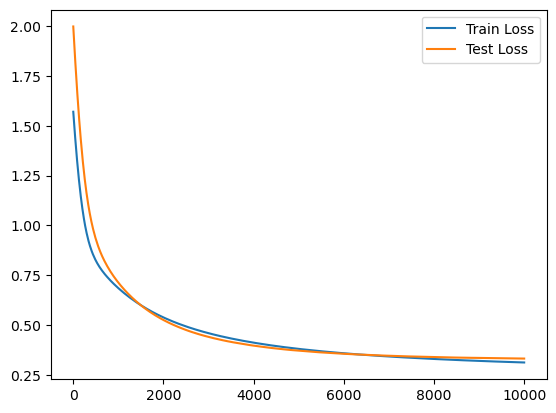

In [17]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()

(e) I would use the model with the 3rd order expansion. It achieves lower loss, and still runs very fast on 1 cpu. It's possible that my simple linear model is just under-trained, so I might put some time into seeing if I could train that further to get the same low loss as I can get on the more complex model.

# Problem 5
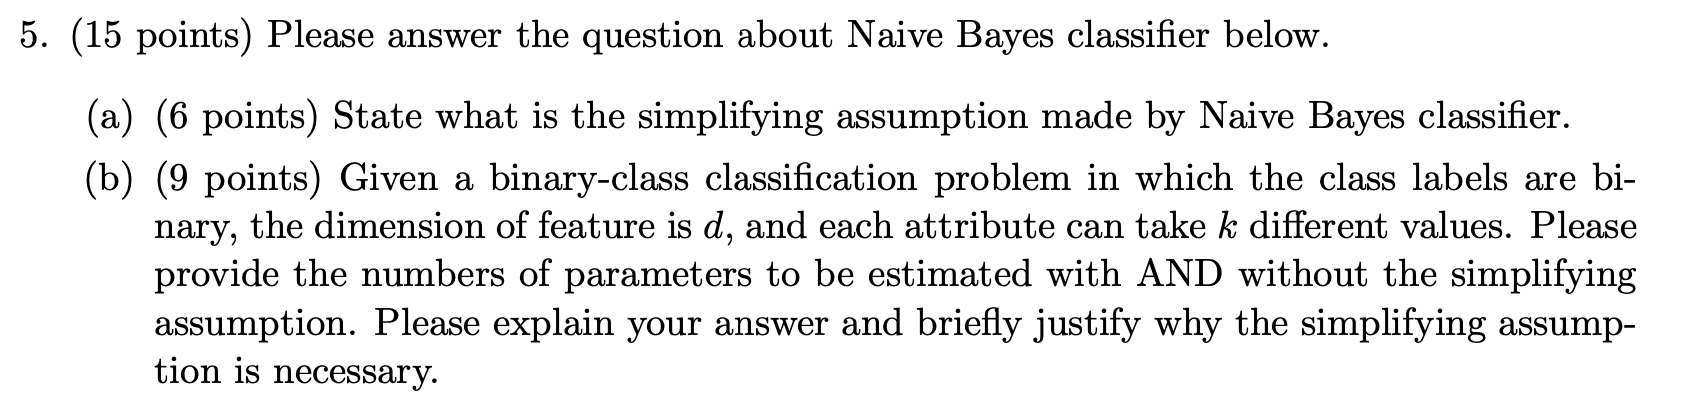